## Backtesting Simple Squiggle
We built a basic bot that interacts with the Betfair API by and makes selections on a simple average of predictions from the Squiggle competition. In this notebook we are going validate/invalidate this idea by back testing against historical data from 2017 & 2018.

### TODO:
1. Format names on all data frames so they are conistent on the join
1. Account for betfair takings in winnings calculation
1. Optimise tip weightings according to given metrics in the squiggle df

In [1]:
import rpy2.rinterface
import pandas as pd

%load_ext rpy2.ipython

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Pull historical tips
We are using an R library to pull down the library.

In [3]:
%%R -o tips_2017 -o tips_2018
tips_2017 <- fitzRoy::get_squiggle_data("tips", year = 2017)
tips_2018 <- fitzRoy::get_squiggle_data("tips", year = 2018)

Concatenate the dataframes pulled from fitzroy in R and find the mean tip confidence for the home team for each match

In [4]:
tips_df = pd.concat([tips_2017, tips_2018])
avg_tip = tips_df[['ateam', 'hteam', 'date', 'hconfidence']].groupby(['ateam', 'hteam', 'date'], as_index=False).mean()
avg_tip.date = pd.to_datetime(avg_tip.date)

Load the oddss data. Drop all unwanted values. Calculate odds

In [5]:
close_18 = pd.read_csv('data/2018.csv')
close_17 = pd.read_csv('data/2017.csv')

df_odds = pd.concat([close_17, close_18])
df_odds = df_odds[df_odds.INPLAY == 'N']
df_odds.drop(['EVENT_ID', 'MENU_HINT', 'EVENT_NAME', 'PATHS',
       'PARENT_MENU_HINT', 'WAP', 'VOLUME_AUD'], axis=1, inplace=True)

df_odds['hteam'] = df_odds.PARENT_EVENT_NAME.apply(lambda x: x.split(' v ')[0])
df_odds = df_odds[df_odds.SELECTION_NAME == df_odds.hteam]
df_odds['ateam'] = df_odds.PARENT_EVENT_NAME.apply(lambda x: x.split(' v ')[1])
df_odds['implied'] = 1 / df_odds.LAST_MATCHED_PRICE
df_odds['date'] = pd.to_datetime(df_odds.SETT_DATE)

Replace the datetime with a date.

In [6]:
df_odds.date = df_odds.date.apply(lambda x: x.date())
avg_tip.date = avg_tip.date.apply(lambda x: x.date())

Join the dataframes.

In [7]:
#TODO: Replace the inconsitent names (e.g., GWS vs Greater Western Sydney)
check_df = df_odds.merge(avg_tip, on=['hteam', 'ateam', 'date'], how='outer').dropna()

### Load Game Results

In [8]:
%%R -o results -o dates
results <- fitzRoy::get_match_results()
dates <- toString(results[['Date']])

### Join Results, compute outcomes

You will see, I am iterating through the dataframe because it returns as not quite a pandas dataframe. Don't know why this is...

In [9]:
for idx, name in enumerate(results.colnames):
    if idx == 0:
        results_df = pd.DataFrame(list(results[idx]),columns=[name])
    else:
        results_df[name] = list(results[idx])

results_df.Date = str(dates[0]).split(', ')
results_df.Date = pd.to_datetime(results_df.Date)

results_df['Year'] = results_df.Date.apply(lambda x: x.year)
results_df = results_df[results_df.Year > 2016]

results_df['date'] = results_df.Date.apply(lambda x: x.date())

# replacing some names to make the merge easier
results_df.columns = ['Game', 'Date', 'Round', 'hteam', 'Home.Goals', 'Home.Behinds',
       'hpoints', 'ateam', 'Away.Goals', 'Away.Behinds', 'apoints',
       'Venue', 'Margin', 'Season', 'Round.Type', 'Round.Number', 'Year', 'date']

df = check_df.merge(results_df[['date','hteam','ateam', 'apoints', 'hpoints']], on=['date', 'hteam', 'ateam'], how='inner')

df.hconfidence /= 100

### Compute bets and returns

We now have the relative odds so we need to execute the logic of what the bet we are making. Here we are simply betting on the home team if confidence is higher than the implied probability, we bet on the away team if confidence is lower the the implied probability.

The winnings are simply the odds times by our stake (set to 1) if we are succesful, or -1 (one negative stake) if we lose.

In [10]:
def bet_made(implied, confidence):
    if implied >= confidence:
        return - (1 / (1 - implied))
    else:
        return 1 / implied

df['bet'] = df[['implied', 'hconfidence']].apply(lambda x: bet_made(x[0], x[1]), axis=1)

In [11]:
def compute_winnings(apoints, hpoints, bet):
    if hpoints > apoints:
        hwin = 1
    else:
        hwin = -1
        
    return max(0, bet*hwin) - 1

df['winnings'] = df[['apoints', 'hpoints', 'bet']].apply(lambda x: compute_winnings(x[0], x[1], x[2]), axis=1)

### Reviewing Results

In [12]:
df.winnings.sum()

21.892687067968815

So over two seasons this strategy returned 21.8 results. Thats mean if the standard bet size was 50AUD it would have returned 1050AUD.

Let's take a look at how we run over this period:

In [13]:
df.winnings.cumsum().plot();

It looks like we:
1. Have an upswing
1. Have a downswing
1. Cash reaaaallll big
1. Then drop some money

This shouldn't convince us we have a winning strategy. Lets take a look at just how big that big win is.

In [14]:
df[df.winnings == df.winnings.max()]

,SETT_DATE,PARENT_EVENT_NAME,SELECTION_NAME,INPLAY,MIN_PRICE,MAX_PRICE,LAST_MATCHED_PRICE,hteam,ateam,implied,date,hconfidence,apoints,hpoints,bet,winnings
71,21/07/2018,Sydney v Gold Coast,Sydney,N,1.03,1.1,1.03,Sydney,Gold Coast,0.970874,2018-07-21,0.907077,88,64,-34.333333,33.333333


This could be an issue with out analysis. This recorded win is 33x a stake. So without this win be lost 12 stakes.

In [15]:
df_no_big = df[df.winnings != df.winnings.max()]
df_no_big.winnings.sum()

-11.440646265364537

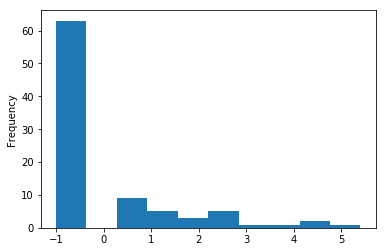

In [16]:
df_no_big.winnings.plot('hist');

This strategy really throws a lot of money at the underdogs. We lose over 60 of the 90 something bets made in the two seasons. Of the remaining 30 or so 9 we at winnings of less than 10. That means we really are picking up the underdogs not always but most of the time.

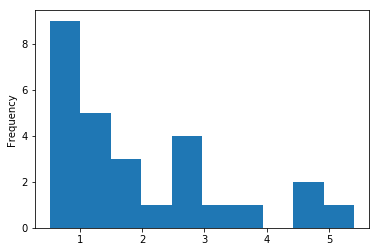

In [17]:
df_no_big[df_no_big.winnings!=-1].winnings.plot('hist');

### Consider the opposite

This testing take no account for the winings taken for betfair, sooo if we layed all the bets we made we would have made money on the majority of bets, losting big on the single loser.

In [18]:
def reverse_bet_made(implied, confidence):
    if implied <= confidence:
        return - (1 / (1 - implied))
    else:
        return 1 / implied

df['bet_reverse'] = df[['implied', 'hconfidence']].apply(lambda x: reverse_bet_made(x[0], x[1]), axis=1)

In [19]:
def compute_winnings(apoints, hpoints, bet):
    if hpoints > apoints:
        hwin = 1
    else:
        hwin = -1
        
    return max(0, bet*hwin) - 1

df['reverse_winnings'] = df[['apoints', 'hpoints', 'bet_reverse']].apply(lambda x: compute_winnings(x[0], x[1], x[2]), axis=1)

In [20]:
df.reverse_winnings.sum()

2.361704786668649

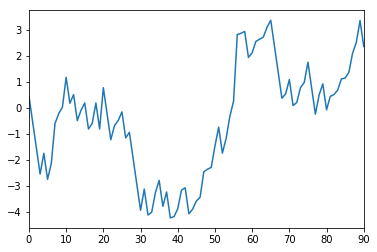

In [21]:
df.reverse_winnings.cumsum().plot();

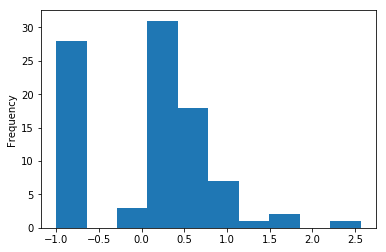

In [22]:
df.reverse_winnings.plot('hist');

### Predictive Power?

So we have implemented a strategy, and implemented the reverse. One is profitably only because of a single very large upset (wether or not this payoff would be as large in the real world needs to be validated) while the other probably doesn't beat the bookies edge.

The payoffs on the second (and indeed possibly the first) give insight into the distribution of payoffs.  The second set we see the binomial distribution we would expect and the payoff of winnings looks very much poisson. We can use this information to model and simulate expected payoffs.

We have to conclude here we don't have a strategy that is consistently going to beat the market. We have a couple of options to improve our model:
1. Dive into the squiggle predictions, pull off selections on their previous rankings and scores.
1. Build our own model using the data in the fitzRoy API
1. Explore other markets including the points scored, and line markets

## References:
- FitzRoy AFL data library in R: https://jimmyday12.github.io/fitzRoy/articles/mens-stats.html
- Squiggle, AFL betting and analysis: https://squiggle.com.au/